In [1]:
# %pylab notebook
import numpy as np 
import h5py
import matplotlib.pyplot as plt
# %matplotlib ipympl

In [2]:
G3Xd = h5py.File('./data/G3X-profiles-progenitors_myevoz.hdf5','r')
GIZd = h5py.File('./data/GIZ-profiles-progenitors_myevoz.hdf5','r')

In [5]:
'''
calculate median profiles and percentile error [16,84] statistically

mod: simulation name [GIZMO or GadgetX]
d: simulation data
snap: which snapshot (equally redshift)
region: which property
ntclu: total cluster number (few clusters may not form at high redshift)
part: which particle part (default 0, this is not meaning DM particles)
'''

def cal_median(rbin, value, nbin):
    xmed = np.zeros(nbin)
    ymed = np.zeros(nbin)
    yerr = np.zeros(shape = (2,nbin))
    
    #calculate the median profile
    for j in range(nbin):
#         nonan = np.where((value[:,j]!= 0) & (np.isnan(value[:,j]) == False))[0]
        nonan = np.where((np.isnan(value[:,j]) == False))[0]
        if len(nonan) > 1:
            ymed[j] = np.median(value[nonan,j])
            xmed[j] = np.median(rbin[nonan,j])
            yerrtot = np.percentile(value[nonan,j],[16,84])
            yerr[0,j] = yerrtot[0]
            yerr[1,j] = yerrtot[1]
    return xmed,ymed,yerr

def cal_sta_profiles(mod,d,snap,region,bin25,ntclu,part = 0):
    nbin = 50
    allvalue=np.zeros(shape = (ntclu,nbin))
    rbinvalue=np.zeros(shape = (ntclu,nbin))
    npvalue=np.zeros(shape = (ntclu,nbin))
    
    redshift = d['NewMDCLUSTER_0001/snap_%03d'%(snap)].attrs['redshift']
    Ez = (0.307*(1 + redshift)**3 + 0.693)**0.5
    
    i = 0
    #read raw data
    for nclu in range(324):
        if 'Rbin' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:          
            continue
        r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
        allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:]
        rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / r500#unit: r/r500
        npvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/NuminBin'%(nclu+1,snap)][0]
        i+=1
    print(i)
              
    allvalue = allvalue * 0.6777**3 * Ez**(-2)*(1+redshift)**3

    if bin25 == True:
        # combine nearby bins with near 2
        rbin25 = np.zeros(shape = (ntclu, 25))
        value25 = np.zeros(shape = (ntclu, 25))
        np25 = np.zeros(shape = (ntclu, 25))
        for i in range(ntclu):
            for j in range(25):
                bin0 = j*2
                bin1 = j*2+1
                value25[i,j] = (allvalue[i,bin0] + allvalue[i,bin1]) / 2
                rbin25[i,j] = (rbinvalue[i,bin0] + rbinvalue[i,bin1]) / 2
                np25[i,j] = npvalue[i,bin0] + npvalue[i,bin1]

        np_med = np.median(np25, axis = 0)
        np25 = np.sum(np25, axis = 1)
        idnp = np.where(np25 >= 50)[0]
        print('input sample is', idnp.shape[0])
        xmed,ymed,yerr = cal_median(rbin25[idnp], value25[idnp], 25)
        return xmed,ymed,yerr,np_med
    else:
        np_med = np.median(npvalue, axis = 0)
        npvalue = np.sum(npvalue, axis = 1)
        idnp = np.where(npvalue >= 50)[0]
        print('input sample is', idnp.shape[0])
        xmed,ymed,yerr = cal_median(rbinvalue[idnp], allvalue[idnp], 50)
        return xmed,ymed,yerr,np_med
    

In [4]:
def ob_Eledens_r500(ax):
    #fit with Vikhlinin+2006
    G2018 = np.loadtxt(open('./data/ob_Eledens/Ghirardini+2018.csv', 'r'),delimiter = ',')
    ob1, = ax.plot(G2018[:,0], G2018[:,1], c = 'grey', ls = '-', label = 'Ghirardini+2019 (z < 0.1)', lw = 2, zorder = -1) 
    #---------------------------------------        
    #Croston+2008
    #RXC J0645.4(z=0.1644)
    #RXC J2157.4(z=0.0579)
    
    #----------------------------------------
    #Keruzore+2020
    K2020 = np.loadtxt(open('./data/ob_Eledens/Keruzore+2020.csv', 'r'),delimiter = ',')
    redshift = 0.865
    Ez = (0.30*(1 + redshift)**3 + 0.7)**0.5
    M500 = 2.48e14 * 0.7 #Msun/h
    r500 = 780.9 #kpc
    xx = K2020[:,0] / r500
    yy = K2020[:,1] * Ez**(-2)
    ob2, = ax.plot(xx, yy, c = 'grey', ls = '--', label = 'Keruzore+2020 (z = 0.865)', lw = 2, zorder = -1)
    
    #----------------------------------------------------------------------------------------
#     #Ruppin+2021
#     from astropy.cosmology import FlatLambdaCDM
#     cosm = FlatLambdaCDM(H0=70, Om0=0.3)
    
#     R2021 = np.loadtxt(open('./data/ob_Eledens/Ruppin+2021_SPT-CLJ0304-4921.csv', 'r'),delimiter = ',')
#     redshift = 0.39
#     Ez = (0.30*(1 + redshift)**3 + 0.7)**0.5
#     M500 = 7.57e14 #Msun
#     pc = cosmo.critical_density(redshift).to('kpc-3Msun').value
#     r500 = (M500 / 500 / 4 * 3 / pc / np.pi)**(1/3)
#     xx = K2020[:,0] / r500
#     yy = K2020[:,1] * Ez**(-2)
#     ax.plot(xx, yy, c = 'grey',ls = '-.', label = 'Ruppin+2021 (z = 0.39)', lw = 2, zorder = -1)
    
    #-------------------------------------
    #Ruppin+2020
    R2020 = np.loadtxt(open('./data/ob_Eledens/Ruppin+2020.csv', 'r'),delimiter = ',')
    redshift = 1.2
    Ez = (0.30*(1 + redshift)**3 + 0.7)**0.5
    r500 = 790 #kpc
    xx = K2020[:,0] / r500
    yy = K2020[:,1] * Ez**(-2)
    ob3, = ax.plot(xx, yy, c = 'grey', ls = ':', label = 'Ruppin+2020 (z = 1.2)', lw = 2, zorder = -1)
    
    

324
input sample is 324
324
input sample is 324
324
input sample is 324
324
input sample is 324
(0,)
324
input sample is 324
324
input sample is 324
(0,)
323
input sample is 323
324
input sample is 324
(0,)
323
input sample is 323
323
input sample is 323
(0,)
323
input sample is 317
323
input sample is 302
(0,)


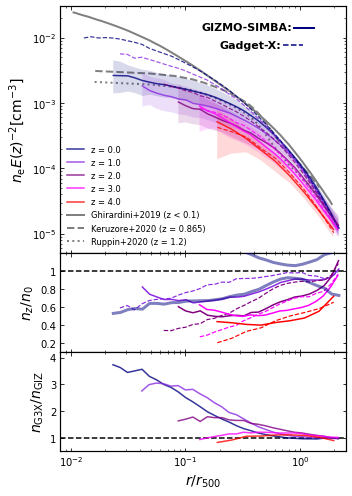

In [7]:
#Combined results
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (5,7))
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((9,4),(0,0),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((9,4),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((9,4),(7,0),colspan = 4,rowspan = 2)

snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0','z = 5.0','z = 6.0']
# colall = ['b','r','k','orange','cyan','magenta','green']
colall = ['navy','blueviolet','purple','magenta','r','tomato','orange']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]
#==========================================================

# GIZMO
for i in [0,1,2,3,4]:
    if i == 0:
        xmed0,ymed0,yerr0,np_med0 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Eledens',False,nGIZ[i])
        xmed25,ymed25,yerr25,np_med25 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Eledens',True,nGIZ[i])
        idt = np.where(np_med0 >= 10)[0]
        ax1.plot(xmed0[idt],ymed0[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha=0.8)
        ax1.fill_between(xmed0[idt],yerr0[0,idt],yerr0[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed0[idt],yerr0[0,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        ax10.plot(xmed0[idt],yerr0[1,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        
        xmed0_x,ymed0_x,yerr0_x,np_med0_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Eledens',False,nG3X[i])
        xmed25_x,ymed25_x,yerr25_x,np_med25_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Eledens',True,nG3X[i])
        idt_x = np.where(np_med0_x >= 10)[0]
        ax1.plot(xmed0_x[idt_x],ymed0_x[idt_x],lw = 1.2, ls = '--',  c=colall[i], zorder = 30,alpha = 0.8)
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed0_x[idt_x],ymed0_x[idt_x]/ymed0[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed0_x[idt],ymed0_x[idt]/ymed0[idt], c=colall[i], zorder = 30,alpha = 0.8)
        # ax20.plot(xmed0_x[idt_x],ymed0_x[idt_x]/ymed0[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        
#         print('GIZ radius',xmed0[idt])
#         print('G3X radius',xmed0_x[idt_x])
        
    elif i <= 3:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'Eledens',False,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed0[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Eledens',False,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed0_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed_x[idt],ymed_x[idt]/ymed[idt], c=colall[i], zorder = 30,alpha = 0.8)
            
        # ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        
    else:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'Eledens',True,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color =colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed25[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Eledens',True,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed25_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed_x[idt],ymed_x[idt]/ymed[idt], c=colall[i], zorder = 30,alpha = 0.8)
        # ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
    print(idt[idt == True].shape)
    
    
ax1.text(0.138,1.3e-2,'GIZMO-SIMBA:',weight = 'bold',size = 11) 
ax1.text(0.2,7e-3,'Gadget-X:',weight = 'bold',size = 11) 

ob_Eledens_r500(ax1)


from matplotlib.lines import Line2D
lin1 = Line2D([],[],c = 'navy',lw = 2)
legend2 = ax1.legend(handles=[lin1],frameon = False, loc = (0.805,0.875))
ax1.add_artist(legend2)

lin0 = Line2D([],[],c = 'navy',lw = 1.5, ls = '--')
legend0 = ax1.legend(handles=[lin0],frameon = False, loc = (0.768,0.805))
ax1.add_artist(legend0)

#==========================================================================
# ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='k',ls='--')

ax1.set_ylabel(r'$n_\mathrm{e} E(z)^{-2}[\mathrm{cm}^{-3}]$', fontsize =14)
ax1.loglog()
ax1.legend(fontsize = 'small', ncol = 1, loc = 3, frameon = False)
ax1.set_xticklabels([])
ax1.set_ylim(5e-6,3e-2)
ax1.set_xlim(0.008,2.5)
# ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.008,2.5)
# ax10.set_xlabel(r'$r/r_{500}$', fontsize = 14)
ax10.set_ylabel(r'$n_z/n_0$', fontsize = 14)
ax10.set_ylim(0.1,1.2)
ax10.set_yticks([0.2,0.4,0.6,0.8,1])
ax10.set_yticklabels([0.2,0.4,0.6,0.8,1])

ax20.axhline(1,c='k',ls='--')
ax20.set_xscale('log')
ax20.set_xlim(0.008,2.5)
ax20.set_ylim(0.5,4.2)
ax20.set_xlabel(r'$r/r_{500}$', fontsize = 14)
ax20.set_ylabel(r'$n_{\rm G3X}/n_{\rm GIZ}$', fontsize = 14)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

ax1.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
ax10.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
plt.tight_layout()
plt.subplots_adjust(wspace =0 ,hspace = 0)
plt.savefig('./figsv2/Eledens.pdf')

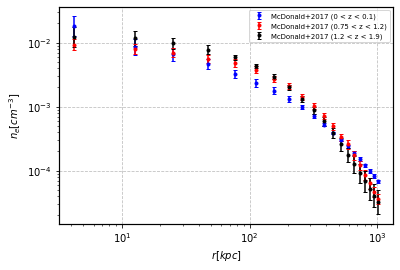

In [6]:
def ob_Eledens():
    #McDonald+2017 (Median profile)
    # 0 < z < 0.1
    x = np.array([6,18,36,67,109,161,222,292,370,454,544,638,737,838,941,1045,1149,1252,1353,1452]) * 0.7 #kpc/h
    y = np.array([-1.74,-2.07,-2.18,-2.33,-2.49,-2.63,-2.75,-2.88,-3.01,-3.15,-3.28,-3.41,-3.52,-3.62,-3.72,-3.82,-3.92,-4.01,-4.09,-4.17])
    yer = np.array([0.15,0.12,0.10,0.08,0.07,0.06,0.05,0.04,0.03,0.03,0.02,0.02,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.03])
    plt.errorbar(x,10**y,yerr = [10**y-10**(y-yer), 10**(y+yer)-10**y], c = 'b',fmt = 'o', label = 'McDonald+2017 (0 < z < 0.1)'
                 ,markersize = 3, zorder = 20, capsize = 2)

    
    # 0.75 < z < 1.2
    x = np.array([6,18,36,67,109,161,222,292,370,454,544,638,737,838,941,1045,1149,1252,1353,1452]) * 0.7 #kpc/h
    y = np.array([-2.03,-2.10,-2.16,-2.26,-2.32,-2.42,-2.57,-2.68,-2.85,-2.99,-3.15,-3.31,-3.48,-3.59,-3.76,-3.92,-4.07,-4.20,-4.33,-4.44])    
    yer = np.array([0.09,0.08,0.07,0.06,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.06,0.06,0.07,0.07,0.07,0.08,0.08,0.08,0.08])
    plt.errorbar(x,10**y,yerr = [10**y-10**(y-yer), 10**(y+yer)-10**y], c = 'r',fmt = 'o', label = 'McDonald+2017 (0.75 < z < 1.2)'
                 ,markersize = 3, zorder = 20, capsize = 2)
    
    # 1.2 < z < 1.9
    x = np.array([6,18,36,67,109,161,222,292,370,454,544,638,737,838,941,1045,1149,1252,1353,1452]) * 0.7 #kpc/h
    y = np.array([-1.91,-1.93,-2.01,-2.11,-2.23,-2.37,-2.53,-2.70,-2.88,-3.06,-3.23,-3.41,-3.59,-3.75,-3.90,-4.04,-4.17,-4.29,-4.39,-4.49])    
    yer = np.array([0.16,0.12,0.09,0.07,0.04,0.03,0.04,0.04,0.05,0.05,0.07,0.08,0.10,0.11,0.13,0.15,0.16,0.17,0.18,0.19])
    plt.errorbar(x,10**y,yerr = [10**y-10**(y-yer), 10**(y+yer)-10**y], c = 'k',fmt = 'o', label = 'McDonald+2017 (1.2 < z < 1.9)'
                 ,markersize = 3, zorder = 20, capsize = 2)
    

    
    #----------------------------------------------------------------------------------------

plt.figure()

ob_Eledens()

plt.xlabel(r'$r[kpc]$')
plt.ylabel(r'$n_e[cm^{-3}]$')
plt.loglog()
plt.legend(fontsize = 'x-small')
# plt.ylim(1e-6,10)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

<IPython.core.display.Javascript object>


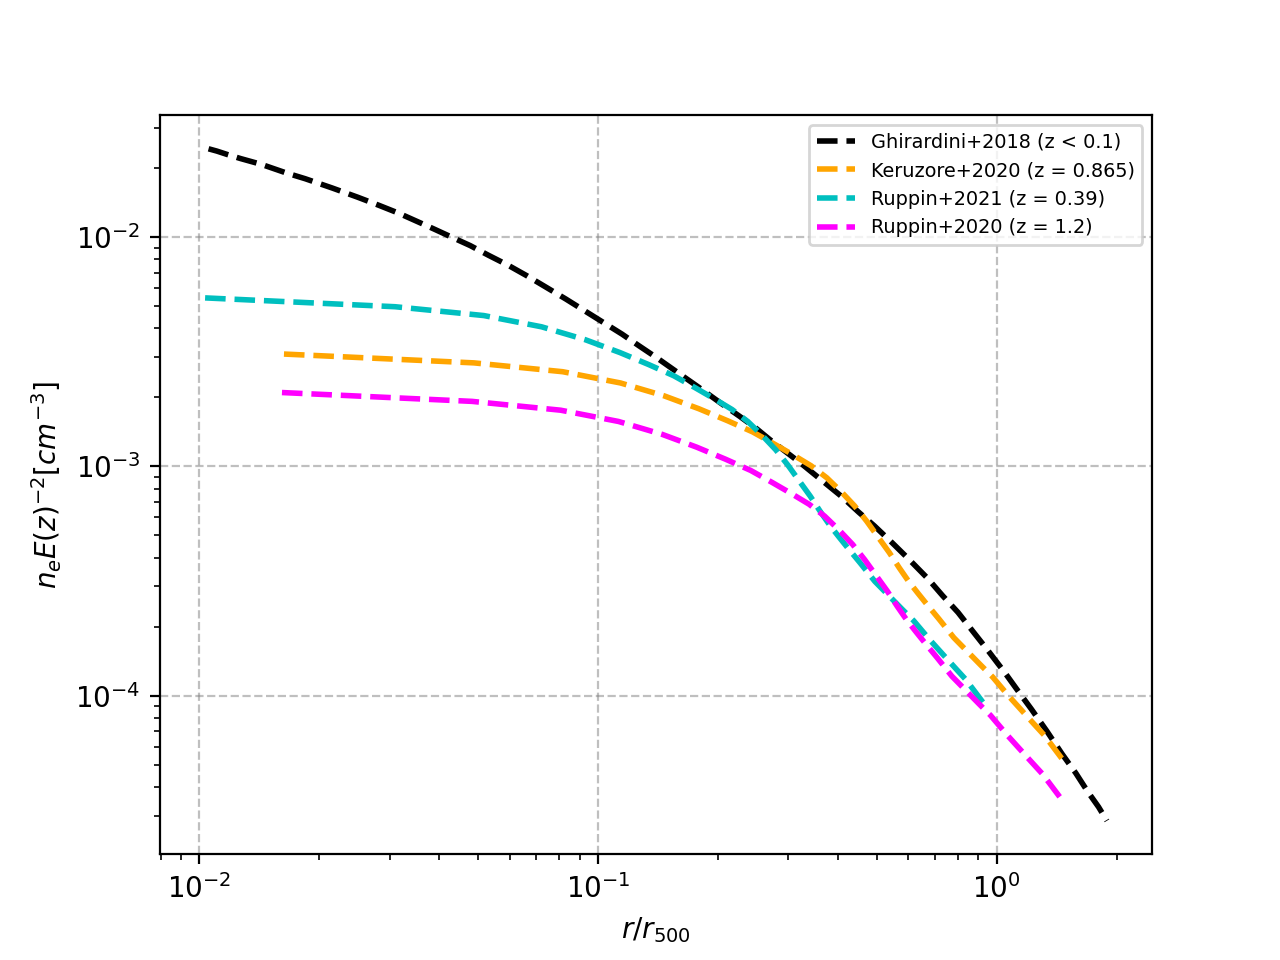

In [75]:
def ob_Eledens_r500():
    #D. Eckert+2012 (This is proton density)
#     xx = np.array([0,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.24,0.27,0.30,0.33,0.37,0.42,0.47,0.52,0.59,0.66,0.74,0.83,0.93,1.05,1.17])
#     nH = np.array([11.447,6.325,3.446,2.222,1.599,1.191,0.923,0.731,0.606,0.506,0.422,0.360,0.289,0.227,0.193
#                   ,0.143,0.121,0.092,0.072,0.059,0.039,0.028])*1e-3
#     err = np.array([0.033,0.018,0.012,0.010,0.009,0.008,0.007,0.007,0.006,0.006,0.005,0.005,0.005,0.004,0.004,
#                    0.004,0.004,0.003,0.003,0.002,0.002,0.002])*1e-3
#     xr = xx * 2 /5
# #     plt.fill_between(xx[1:], nH-err, nH+err, alpha = 0.6, color = 'r', label = 'scaled Eckert+2012')
#     for i in range(xx.shape[0]-1):
#         xr = np.linspace(xx[i],xx[i+1],100)
#         ylow = nH[i]-err[i]
#         yup = nH[i]+err[i]
#         if i == 0:
#             plt.fill_between(xr, ylow, yup, alpha = 0.6, color = 'r', label = 'scaled Eckert+2012')
#         else:
#             plt.fill_between(xr, ylow, yup, alpha = 0.6, color = 'r')

    #--------------------------------------
    #Ghirardini+2018
#     xx = np.array([0.01,0.07,0.13,0.21,0.31,0.46,0.72,1.15,2.00])
#     A = np.array([13.00,3.44,2.60,2.85,1.84,1.63,1.42,1.53])*1e-4
#     B = np.array([-0.48,-1.04,-1.21,-1.16,-1.60,-1.80,-2.38,-2.47])
#     sigma_int = np.array([0.38,0.28,0.18,0.15,0.15,0.18,0.27,0.37])
#     def piecewise_func(xx,A,B,sigma_int):
#         return A*xx**B*np.exp(sigma_int)
#     for i in range(8):
#         xr = np.linspace(xx[i],xx[i+1],100)
#         ye = piecewise_func(xr,A[i],B[i],sigma_int[i])
#         if i == 0:
#             plt.plot(xr,ye,'c--',lw = 2,label = 'Ghirardini+2018 (z < 0.1)')
#         else:
#             plt.plot(xr,ye,'c--',lw = 2)
            
    #fit with Vikhlinin+2006
    G2018 = np.loadtxt(open('./data/ob_Eledens/Ghirardini+2018.csv', 'r'),delimiter = ',')
    plt.plot(G2018[:,0], G2018[:,1], c = 'k', ls = '--', label = 'Ghirardini+2018 (z < 0.1)', lw = 2, zorder = 102) 
    #---------------------------------------        
    #Croston+2008
    #RXC J0645.4(z=0.1644)
    #RXC J2157.4(z=0.0579)
    
    #----------------------------------------
    #Keruzore+2020
    K2020 = np.loadtxt(open('./data/ob_Eledens/Keruzore+2020.csv', 'r'),delimiter = ',')
    redshift = 0.865
    Ez = (0.30*(1 + redshift)**3 + 0.7)**0.5
    M500 = 2.48e14 * 0.7 #Msun/h
    r500 = 780.9 #kpc
    xx = K2020[:,0] / r500
    yy = K2020[:,1] * Ez**(-2)
    plt.plot(xx, yy, c = 'orange', ls = '--', label = 'Keruzore+2020 (z = 0.865)', lw = 2, zorder = 102)
    
    #----------------------------------------------------------------------------------------
    #Ruppin+2021
    from astropy.cosmology import FlatLambdaCDM
    cosm = FlatLambdaCDM(H0=70, Om0=0.3)
    
    R2021 = np.loadtxt(open('./data/ob_Eledens/Ruppin+2021_SPT-CLJ0304-4921.csv', 'r'),delimiter = ',')
    redshift = 0.39
    Ez = (0.30*(1 + redshift)**3 + 0.7)**0.5
    M500 = 7.57e14 #Msun
    pc = cosmo.critical_density(redshift).to('kpc-3Msun').value
    r500 = (M500 / 500 / 4 * 3 / pc / np.pi)**(1/3)
    xx = K2020[:,0] / r500
    yy = K2020[:,1] * Ez**(-2)
    plt.plot(xx, yy, 'c--', label = 'Ruppin+2021 (z = 0.39)', lw = 2, zorder = 102)
    
    #-------------------------------------
    #Ruppin+2020
    R2020 = np.loadtxt(open('./data/ob_Eledens/Ruppin+2020.csv', 'r'),delimiter = ',')
    redshift = 1.2
    Ez = (0.30*(1 + redshift)**3 + 0.7)**0.5
    r500 = 790 #kpc
    xx = K2020[:,0] / r500
    yy = K2020[:,1] * Ez**(-2)
    plt.plot(xx, yy, c = 'magenta', ls = '--', label = 'Ruppin+2020 (z = 1.2)', lw = 2, zorder = 102)
    
    
plt.figure()

ob_Eledens_r500()

plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$n_e E(z)^{-2}[cm^{-3}]$')
plt.loglog()
plt.legend(fontsize = 'x-small')
# plt.ylim(1e-6,10)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)

<IPython.core.display.Javascript object>


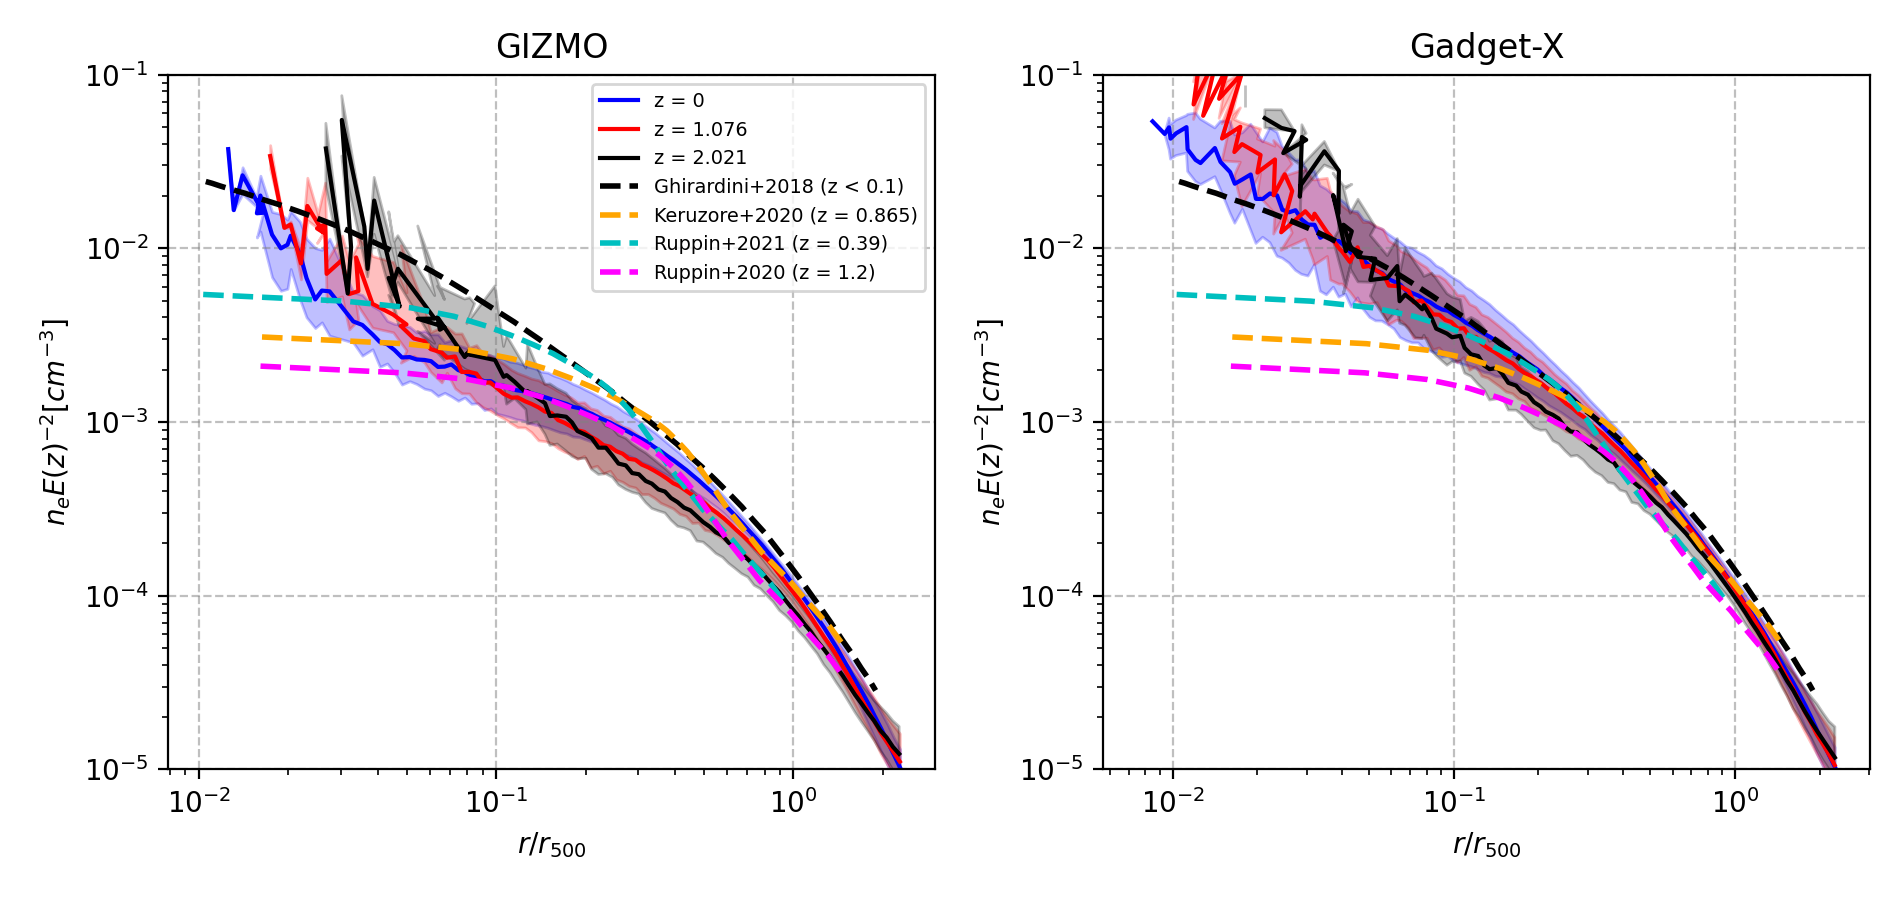

324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


In [76]:
#electron number density

plt.figure(figsize = (9.5,4.5))

plt.subplot(121)
#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Eledens',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Eledens',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Eledens',323)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

# ob_Eledens()
ob_Eledens_r500()

plt.title('GIZMO')
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$n_e E(z)^{-2}[cm^{-3}]$')
plt.loglog()
plt.legend(fontsize = 'x-small')
plt.ylim(1e-5,1e-1)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)
# plt.xlim(1e-2,3)


plt.subplot(122)

#z = 0
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,128,'Eledens',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,95,'Eledens',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,78,'Eledens',324)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

# ob_Eledens()
ob_Eledens_r500()

plt.title('Gadget-X')
plt.xlabel(r'$r/r_{500}$') 
plt.ylabel(r'$n_e E(z)^{-2}[cm^{-3}]$')
plt.loglog()
plt.ylim(1e-5,1e-1)
# plt.xlim(1e-2,3)
plt.grid(c = 'grey', ls = '--', alpha = 0.5)
plt.tight_layout()

<IPython.core.display.Javascript object>


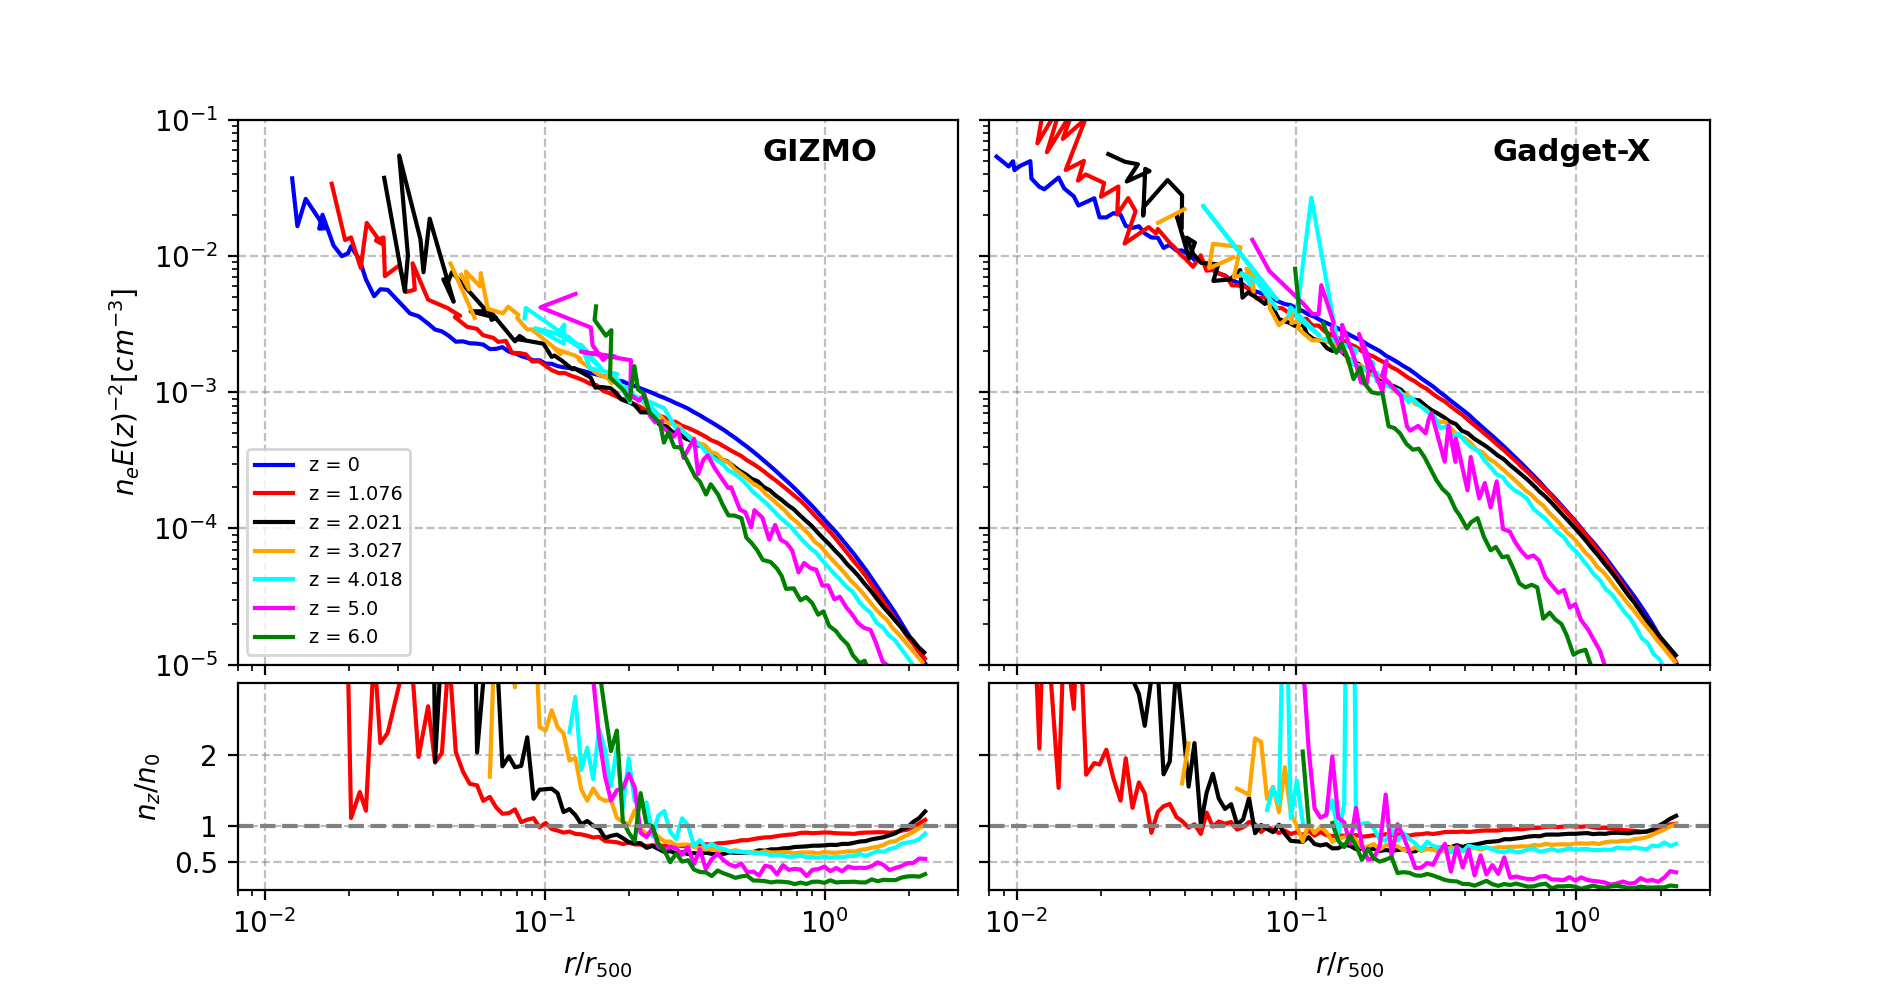

324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


318


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


306


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


320


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


305


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

In [9]:
#study evolution of gas density
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (9.5,5))
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((7,8),(0,0),colspan = 4,rowspan = 5)
ax2 = plt.subplot2grid((7,8),(0,4),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((7,8),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((7,8),(5,4),colspan = 4,rowspan = 2)

snapb = [128,95,78,65,55,47,40]
redb = ['z = 0','z = 1.076','z = 2.021','z = 3.027','z = 4.018','z = 5.0','z = 6.0']
colall = ['b','r','k','orange','cyan','magenta','g']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]

for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Eledens',nGIZ[i])
        ax1.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Eledens',nGIZ[i])
        ax1.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax10.plot(xmed0,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='grey',ls='--')

ax1.text(0.6,5e-2,'GIZMO',weight = 'bold',size = 11)
ax1.set_ylabel(r'$n_e E(z)^{-2}[cm^{-3}]$')
ax1.loglog()
ax1.legend(fontsize = 'x-small', loc = 3)
ax1.set_xticklabels([])
ax1.set_ylim(1e-5,1e-1)
ax1.set_xlim(0.008,3)
ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.008,3)
ax10.set_ylim(0.1,3)
ax10.set_xlabel(r'$r/r_{500}$')
ax10.set_ylabel(r'$n_z/n_0$')
ax10.set_yticks([0.5,1,2])
ax10.set_yticklabels([0.5,1,2])

#Gadget-X
for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'Eledens',nG3X[i])
        ax2.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'Eledens',nG3X[i])
        ax2.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax20.plot(xmed0,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax20.grid(c = 'grey', ls = '--', alpha = 0.5)
ax20.axhline(1,c='grey',ls='--')
ax2.text(0.5,5e-2,'Gadget-X',weight = 'bold',size = 11)

ax2.loglog()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(c = 'grey', ls = '--', alpha = 0.5)
ax2.set_ylim(1e-5,1e-1)
ax2.set_xlim(0.008,3)

ax20.set_xscale('log')
ax20.set_xlim(0.008,3)
ax20.set_ylim(0.1,3)
ax20.set_xlabel(r'$r/r_{500}$')
ax20.set_yticks([0.5,1,2])
ax20.set_yticklabels([])
# plt.savefig('./figs/Gdens.pdf')
# plt.tight_layout()

In [3]:
plt.figure()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

def cal_one_profiles(mod,d,snap,region,pty,nclu):
    nbin = 150
    allvalue=np.zeros(shape = (nbin))
    rbinvalue=np.zeros(shape = (nbin))
    npvalue=np.zeros(shape = (nbin))
    redshift = d['NewMDCLUSTER_0001_%s/snap_%03d'%(pty,snap)].attrs['redshift']
    Ez = (0.307*(1 + redshift)**3 + 0.693)**0.5
    
    M500 = d['NewMDCLUSTER_%04d_%s/snap_%03d'%(nclu+1,pty,snap)].attrs['M500']

    r500 = d['NewMDCLUSTER_%04d_%s/snap_%03d'%(nclu+1,pty,snap)].attrs['r500']
    allvalue = d['NewMDCLUSTER_%04d_%s/snap_%03d/%s'%(nclu+1,pty,snap,region)][:]
    rbinvalue = d['NewMDCLUSTER_%04d_%s/snap_%03d/Rbin'%(nclu+1,pty,snap)][:] / r500 #unit: r/r500  
    
    allvalue = allvalue * Ez**(-2)*(1+redshift)**3
    return rbinvalue,allvalue

GIZd = h5py.File('./data/test/GIZ-profiles-evoz_clu1.hdf5','r')

xmed,ymed = cal_one_profiles('GIZ',GIZd,128,'Gdens','delaytime',nclu = 0)
plt.plot(xmed,ymed,c='b',label = 'z = 0')

#z = 1.076
xmed,ymed = cal_one_profiles('GIZ',GIZd,95,'Gdens','delaytime',nclu = 0)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')

#z = 2.021
xmed,ymed = cal_one_profiles('GIZ',GIZd,78,'Gdens','delaytime',nclu = 0)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')

#--------------------------------------------
# xmed,ymed = cal_one_profiles('GIZ',GIZd,128,'MWTemp','nowind',nclu = 0)
# plt.plot(xmed,ymed,c='b',label = 'z = 0 (no wind)',ls = '--')

# #z = 1.076
# xmed,ymed = cal_one_profiles('GIZ',GIZd,95,'MWTemp','nowind',nclu = 0)
# plt.plot(xmed,ymed,c='r',label = 'z = 1.076 (no wind)',ls = '--')

# #z = 2.021
# xmed,ymed = cal_one_profiles('GIZ',GIZd,78,'MWTemp','nowind',nclu = 0)
# plt.plot(xmed,ymed,c='k',label = 'z = 2.021 (no wind)', ls = '--')
GIZd.close()
# #--------------------------------------------

plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$n_e[cm^{-3}]$')
plt.loglog()
# plt.ylim(1e-6,1e-1)

plt.title('Cluster 1')
plt.grid(c = 'grey', ls = '--', alpha = 0.5)
# plt.xlim(1e-2,3)

plt.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


318


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


306


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


320


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


305


/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda-mamba/envs/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
